The purpose of this notebook is to consider alternative models for churn prediction.  
This series of notebook is also available at https://github.com/databricks-industry-solutions/churn. You can find more information about this accelerator at https://www.databricks.com/solutions/accelerators/retention-management.

###Step 1: Prepare Features & Labels

Our first step is to retrieve the features and labels with which we will train and evaluate our models.  The data preparation logic was examined in the last two notebooks:

In [0]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier

from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, log_loss, precision_recall_curve, auc, average_precision_score
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import pandas as pd
import numpy as np

/databricks/python/lib/python3.9/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [0]:
# please use a personalized database name here, if you wish to avoid interfering with other users who might be running this accelerator in the same workspace
database_name = 'customer_churn'
spark.sql(f'USE {database_name}')

Out[3]: DataFrame[]

In [0]:
!pip install mlflow

     |██████▎ 

*** WARNING: max output size exceeded, skipping output. ***

     |████████████████████████████████| 2.8 MB 34.8 MB/s 
     |████████████████████████████████| 610 kB 64.1 MB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Not uninstalling typing-extensions at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-1e5180a2-8387-4575-b720-39ab74b1ceb3
    Can't uninstall 'typing-extensions'. No files were found to uninstall.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-1e5180a2-8387-4575-b720-39ab74b1ceb3/bin/python -m pip install --upgrade pip' command.


In [0]:
token = dbutils.notebook.entry_point.getDbutils().notebook().getContext().apiToken().get()
dbutils.fs.put(“file:///root/.databrickscfg”,”[DEFAULT]\nhost=https://community.cloud.databricks.com\ntoken = “+token,overwrite=True)

  File <command-4084284757752760>:2
    dbutils.fs.put(“file:///root/.databrickscfg”,”[DEFAULT]\nhost=https://community.cloud.databricks.com\ntoken = “+token,overwrite=True)
                   ^
SyntaxError: invalid character '“' (U+201C)


In [0]:
# import mlflow
useremail = dbutils.notebook.entry_point.getDbutils().notebook().getContext().userName().get()
experiment_name = f"/Users/{useremail}/churn"
print(experiment_name)
mlflow.set_experiment(experiment_name) 

/Users/dipika.dhara@kasmo.co/churn
Out[4]: <Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/4084284757752761', creation_time=1689321995471, experiment_id='4084284757752761', last_update_time=1689618545240, lifecycle_stage='active', name='/Users/dipika.dhara@kasmo.co/churn', tags={'mlflow.experiment.sourceName': '/Users/dipika.dhara@kasmo.co/churn',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'dipika.dhara@kasmo.co',
 'mlflow.ownerId': '5184971542956623'}>

In [0]:
# # retrieve training dataset
# train = spark.sql('''
#   SELECT
#     a.*,
#     b.days_total,
#     b.days_with_session,
#     b.ratio_days_with_session_to_days,
#     b.days_after_exp,
#     b.days_after_exp_with_session,
#     b.ratio_days_after_exp_with_session_to_days_after_exp,
#     b.sessions_total,
#     b.ratio_sessions_total_to_days_total,
#     b.ratio_sessions_total_to_days_with_session,
#     b.sessions_total_after_exp,
#     b.ratio_sessions_total_after_exp_to_days_after_exp,
#     b.ratio_sessions_total_after_exp_to_days_after_exp_with_session,
#     b.seconds_total,
#     b.ratio_seconds_total_to_days_total,
#     b.ratio_seconds_total_to_days_with_session,
#     b.seconds_total_after_exp,
#     b.ratio_seconds_total_after_exp_to_days_after_exp,
#     b.ratio_seconds_total_after_exp_to_days_after_exp_with_session,
#     b.number_uniq,
#     b.ratio_number_uniq_to_days_total,
#     b.ratio_number_uniq_to_days_with_session,
#     b.number_uniq_after_exp,
#     b.ratio_number_uniq_after_exp_to_days_after_exp,
#     b.ratio_number_uniq_after_exp_to_days_after_exp_with_session,
#     b.number_total,
#     b.ratio_number_total_to_days_total,
#     b.ratio_number_total_to_days_with_session,
#     b.number_total_after_exp,
#     b.ratio_number_total_after_exp_to_days_after_exp,
#     b.ratio_number_total_after_exp_to_days_after_exp_with_session,
#     c.is_churn
#   FROM train_trans_features a
#   INNER JOIN train_act_features b
#     ON a.msno=b.msno
#   INNER JOIN train c
#     ON a.msno=c.msno
#   ''').toPandas()

# # retrieve training dataset
# test = spark.sql('''
#   SELECT
#     a.*,
#     b.days_total,
#     b.days_with_session,
#     b.ratio_days_with_session_to_days,
#     b.days_after_exp,
#     b.days_after_exp_with_session,
#     b.ratio_days_after_exp_with_session_to_days_after_exp,
#     b.sessions_total,
#     b.ratio_sessions_total_to_days_total,
#     b.ratio_sessions_total_to_days_with_session,
#     b.sessions_total_after_exp,
#     b.ratio_sessions_total_after_exp_to_days_after_exp,
#     b.ratio_sessions_total_after_exp_to_days_after_exp_with_session,
#     b.seconds_total,
#     b.ratio_seconds_total_to_days_total,
#     b.ratio_seconds_total_to_days_with_session,
#     b.seconds_total_after_exp,
#     b.ratio_seconds_total_after_exp_to_days_after_exp,
#     b.ratio_seconds_total_after_exp_to_days_after_exp_with_session,
#     b.number_uniq,
#     b.ratio_number_uniq_to_days_total,
#     b.ratio_number_uniq_to_days_with_session,
#     b.number_uniq_after_exp,
#     b.ratio_number_uniq_after_exp_to_days_after_exp,
#     b.ratio_number_uniq_after_exp_to_days_after_exp_with_session,
#     b.number_total,
#     b.ratio_number_total_to_days_total,
#     b.ratio_number_total_to_days_with_session,
#     b.number_total_after_exp,
#     b.ratio_number_total_after_exp_to_days_after_exp,
#     b.ratio_number_total_after_exp_to_days_after_exp_with_session,
#     c.is_churn
#   FROM test_trans_features a
#   INNER JOIN test_act_features b
#     ON a.msno=b.msno
#   INNER JOIN test c
#     ON a.msno=c.msno
#   ''').toPandas()


# # separate features and labels
# X_train_raw = train.drop(['msno','is_churn'], axis=1)
# y_train = train['is_churn']

# # separate features and labels
# X_test_raw = test.drop(['msno','is_churn'], axis=1)
# y_test = test['is_churn']


In [0]:
# print(train.shape)
# print(test.shape)
# print(X_train_raw.shape)
# print(X_test_raw.shape)
# print(y_train.shape)
# print(y_test.shape)

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
<command-3510043554929416> in <cell line: 1>()
----> 1 print(train.shape)
      2 print(test.shape)
      3 print(X_train_raw.shape)
      4 print(X_test_raw.shape)
      5 print(y_train.shape)

NameError: name 'train' is not defined

In [0]:
# X_test_raw.columns

Out[43]: Index(['start_year', 'start_month', 'subscription_age', 'renewals',
       'total_list_price', 'total_amount_paid', 'total_discount',
       'days_since_last_account_action', 'last_plan_list_price',
       'last_actual_amount_paid', 'last_discount', 'last_payment_plan_days',
       'last_payment_method', 'last_is_cancel', 'last_is_auto_renew',
       'last_change_in_list_price', 'last_change_in_discount',
       'last_change_in_payment_plan_days', 'last_change_in_payment_method_id',
       'last_change_in_cancellation', 'last_change_in_auto_renew',
       'last_days_change_in_membership_expire_date', 'days_until_expiration',
       'total_subscription_count', 'city', 'bd', 'gender', 'registered_via',
       'days_total', 'days_with_session', 'ratio_days_with_session_to_days',
       'days_after_exp', 'days_after_exp_with_session',
       'ratio_days_after_exp_with_session_to_days_after_exp', 'sessions_total',
       'ratio_sessions_total_to_days_total',
       'ratio_sessions_

Our feature sets, *X_train_raw* and *X_test_raw*, need to be transformed to address missing and categorical values.  In addition, we need to scale our continuous features to align them with the requirements of some of the models we will evaluate:

In [0]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def transform_df(train_set_path,test_set_path):
    train = pd.read_csv(train_set_path,index_col =0)
    test = pd.read_csv(test_set_path,index_col =0)


    # separate features and labels
    X_train_raw = train.drop(['msno','is_churn'], axis=1)
    y_train = train['is_churn']

    # separate features and labels
    X_test_raw = test.drop(['msno','is_churn'], axis=1)
    y_test = test['is_churn']

    # replace missing values
    impute = ColumnTransformer(
    transformers=[('missing values', SimpleImputer(strategy='most_frequent'), ['last_payment_method', 'city', 'gender', 'registered_via', 'bd'])],
    remainder='passthrough'
    )

    # encode categoricals and scale all others
    encode_scale =  ColumnTransformer( 
    transformers= [('ohe categoricals', OneHotEncoder(categories='auto', drop='first'), slice(0,4))], # features 0 through 3 should be the first four features imputed in previous step
    remainder= StandardScaler()  # standardize all other features
    )

    # package transformation logic
    transform = Pipeline([
    ('impute', impute),
    ('encode_scale', encode_scale)
    ])

    # apply transformations
    X_train = transform.fit_transform(X_train_raw)
    X_test = transform.transform(X_test_raw)
    print("X_train shape: ",X_train.shape)
    print("------------------------------------------")
    print("X_test shape: ",X_test.shape)

    return train,test,X_train,y_train,y_test,X_test

train_path = "/dbfs/FileStore/Customer_Churn_Datasets/Datasets/train.csv"
test_path = "/dbfs/FileStore/Customer_Churn_Datasets/Datasets/test.csv"
train,test,X_train,y_train,y_test,X_test=transform_df(train_path,test_path)

X_train shape:  (856143, 102)
------------------------------------------
X_test shape:  (853903, 102)


###Step 2: Examine Evaluation Metrics

Churn prediction is typically addressed as a binary classification problem where a customer or subscription that has churned is identified as the *positive class*, *i.e.* assigned a churn label of 1, and a customer or subscription that has not churned is identified as the *negative class*, *i.e.* assigned a churn label of 0. In a well-run business, the number of churn events taking place in a given time period should be fairly low, creating an imbalance between the occurrence of negative and positive class events.  Another way of saying this is that the positive class is the *minority class* and the negative class is the *majority class*.  While great for the business, the imbalance between the minority and majority classes can create problems for the algorithms tasked with learning a predictive solution.

To understand this, let's examine the imbalance between negative and positive churn events in our training and testing datasets:

In [0]:
# %sql

# SELECT
#   CONCAT(is_churn,' - ',CASE WHEN is_churn=0 THEN 'not churned' ELSE 'churned' END) as class,
#   dataset,
#   count(*) as instances
# FROM (
#   SELECT
#     is_churn, 'train' as dataset
#   FROM train
#   UNION ALL
#   SELECT
#     is_churn, 'test' as dataset
#   FROM test
#   ) 
# GROUP BY is_churn, dataset
# ORDER BY is_churn DESC

---------------------------------------------------------------------------
AnalysisException                         Traceback (most recent call last)
File <command-3659920505602649>:7
      5     display(df)
      6     return df
----> 7   _sqldf = ____databricks_percent_sql()
      8 finally:
      9   del ____databricks_percent_sql

File <command-3659920505602649>:4, in ____databricks_percent_sql()
      2 def ____databricks_percent_sql():
      3   import base64
----> 4   df = spark.sql(base64.standard_b64decode("U0VMRUNUCiAgQ09OQ0FUKGlzX2NodXJuLCcgLSAnLENBU0UgV0hFTiBpc19jaHVybj0wIFRIRU4gJ25vdCBjaHVybmVkJyBFTFNFICdjaHVybmVkJyBFTkQpIGFzIGNsYXNzLAogIGRhdGFzZXQsCiAgY291bnQoKikgYXMgaW5zdGFuY2VzCkZST00gKAogIFNFTEVDVAogICAgaXNfY2h1cm4sICd0cmFpbicgYXMgZGF0YXNldAogIEZST00gdHJhaW4KICBVTklPTiBBTEwKICBTRUxFQ1QKICAgIGlzX2NodXJuLCAndGVzdCcgYXMgZGF0YXNldAogIEZST00gdGVzdAogICkgCkdST1VQIEJZIGlzX2NodXJuLCBkYXRhc2V0Ck9SREVSIEJZIGlzX2NodXJuIERFU0M=").decode())
      5   display(df)
      6   return 

In [0]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(856143, 102)
(853903, 102)
(856143,)
(853903,)


Out[3]: Text(0.5, 1.0, 'not churn vs is_churn')

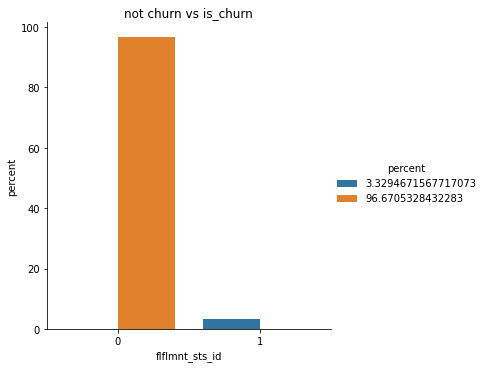

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
# train.head()
count = train['is_churn'].value_counts(normalize=True).mul(100).reset_index(drop=False)
count.columns = ['flflmnt_sts_id','percent']
(count.pipe((sns.catplot,'data'), x='flflmnt_sts_id',y='percent',hue='percent',kind='bar'))
plt.title('not churn vs is_churn')

In [0]:
is_churn_df = train[(train['is_churn']==1)]
# is_chu rn_df.head()

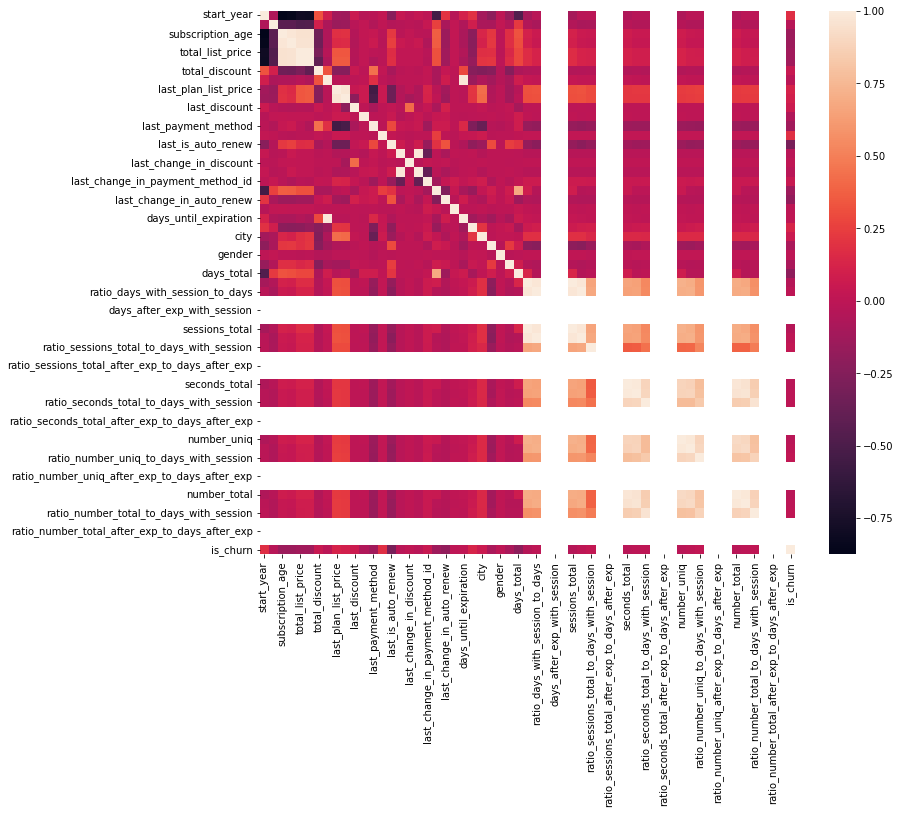

In [0]:
plt.subplots(figsize=(12,10))
data=train.corr()
sns.heatmap(data)
plt.show()

With between 96 and 97% of our subscribers not churning in these two periods, we can achieve a very high accuracy score with a naive model that simply labels **every instance** as *not churning*:

In [0]:
# generate naive churn prediction of ALL negative class
naive_y_pred = np.zeros(y_test.shape[0], dtype='int32')

print('Naive model Accuracy:\t{0:.6f}'.format( accuracy_score(y_test, naive_y_pred)))

Naive model Accuracy:	0.960573


While we achieve what may look like a pretty decent score, we know this model does not align with our goal of identifying churning customers.  Let's take a look at how a trained model compares:

In [0]:
# train the model
trained_model = LogisticRegression(max_iter=1000)
trained_model.fit(X_train, y_train)

# predict
trained_y_pred = trained_model.predict(X_test)

# calculate accuracy
print('Trained Model Accuracy:\t{0:.6f}'.format(accuracy_score(y_test, trained_y_pred)))

Trained Model Accuracy:	0.962916


In imbalanced scenarios, accuracy provides a very poor assessment of model performance.  Models with little to no skill can obtain high accuracy scores by simply leaning on majority class predictions. A better approach to model evaluation is to leverage metrics that examine the model's ability to predict the positive class as the positive class is considered to be of higher value or importance in a churn prediction scenario.  [Precision, recall and F1 scores](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html) are commonly used for this kind of evaluation.

Still, metrics such as these don't tell the whole story. Each is calculated based on a predicted class assignment, *i.e.* 0 or 1.  Under the covers, the model is actually predicting a class probability, and those probabilities provide far more information than a simple class assignment:

In [0]:
# # predict class assignment probabilities
# trained_y_prob = trained_model.predict_proba(X_test)
# trained_y_prob[110:120]

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-3659920505602659>:2
      1 # predict class assignment probabilities
----> 2 trained_y_prob = trained_model.predict_proba(X_test)
      3 trained_y_prob[110:120]

NameError: name 'trained_model' is not defined

Similar probabilities might be assigned to our naive model using the proportion of each class in the training dataset:

In [0]:
# calculate ratio of negative class instances in training dataset
label_counts = np.unique(y_train, return_counts=True)[1]
negclass_prop = label_counts[0]/np.sum(label_counts)

# construct a set of class probabilities representing class proportions in training set
naive_y_prob = np.empty(trained_y_prob.shape, dtype='float')
naive_y_prob[:] = [negclass_prop, 1-negclass_prop]

# display results
naive_y_prob

Out[10]: array([[0.96670533, 0.03329467],
       [0.96670533, 0.03329467],
       [0.96670533, 0.03329467],
       ...,
       [0.96670533, 0.03329467],
       [0.96670533, 0.03329467],
       [0.96670533, 0.03329467]])

To arrive at a class assignment, a threshold value is applied to the class probabilities. If one class or the other is above the threshold, that determines which class label is assigned to an instance. For the F1, precision and recall metrics mentioned previously, a threshold value must be set and the metric calculated based on label assignments.  The *predict()* method uses a 50% threshold but we could easily assign labels based on one of our choosing.

The more fundamental problem is that we don't know what an appropriate threshold is just yet.  And our threshold may vary by customer instance based on things like a customer's revenue/profit potential or other factors.  When our goal is to evaluate a model based on its predictive capacity over a range of potential threshold values, we might consider metrics that examine the prediction probabilities relative to the actual class labels.  One of the most popular of these is the ROC AUC score:

**NOTE** Only positive class probabilities are needed for this and similar metrics. The probability assigned to the positive class plus the probability assigned to the negative class will always equal 1.0.

In [0]:
# calculate ROC AUC for trained & naive models
trained_auc = roc_auc_score(y_test, trained_y_prob[:,1])
naive_auc = roc_auc_score(y_test, naive_y_prob[:,1])

print('Trained ROC AUC:\t{0:.6f}'.format(trained_auc))
print('Naive ROC AUC:\t\t{0:.6f}'.format(naive_auc))

Trained ROC AUC:	0.881532
Naive ROC AUC:		0.500000


The ROC AUC score measures the area under a receiver operator curve. The receiver operator curve (ROC) plots the shift in balance between true positive and false positive predictions as you increase the probability threshold with which you would identify an instance as a member of either the negative or positive class. Measuring the area addressed under this curve, we can identify the predictive capacity of our model across the complete range of threshold values.  The 0.50 score assigned to the naive model indicates it really has not predictive skill while the nearly 90% score assigned to the logistic regression model indicates it is far more certain of its predictions, even if the two models make very similar predictions at a 50% threshold (as reflected by their near identical accuracy scores).  Still, there is room for improvement as a perfect predictor can achieve a maximum ROC AUC score of 1.00.

Visualizing the curve (and the area under it) makes the concept of area under the curve (AUC) a little easier to understand:

**NOTE** In the chart below, the AUC for the naive model is shaded in purple while the AUC for the trained model encompasses both the red and purple shaded areas.

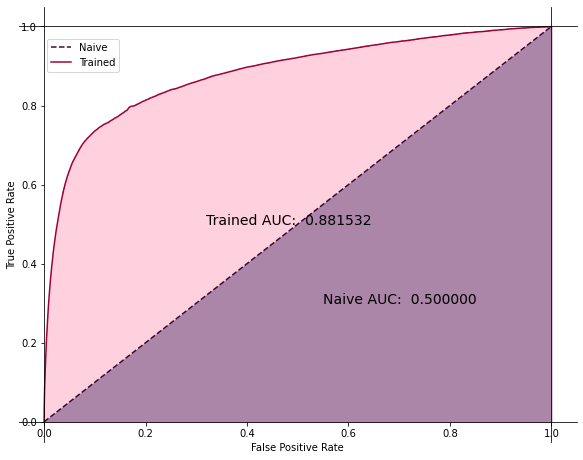

In [0]:
trained_fpr, trained_tpr, trained_thresholds = roc_curve(y_test, trained_y_prob[:,1])
naive_fpr, naive_tpr, naive_thresholds = roc_curve(y_test, naive_y_prob[:,1])

# define the plot
fig, ax = plt.subplots(figsize=(10,8))

# plot the roc curve for the model
plt.plot(naive_fpr, naive_tpr, linestyle='--', label='Naive', color='xkcd:eggplant')
plt.plot(trained_fpr, trained_tpr, linestyle='solid', label='Trained', color='xkcd:cranberry')

# shade the area under the curve
ax.fill_between(trained_fpr, trained_tpr, 0, color='xkcd:light pink')
ax.fill_between(naive_fpr, naive_tpr, 0, color='xkcd:dusty lavender')

# label each curve with is ROC AUC score
ax.text(.55, .3, 'Naive AUC:  {0:.6f}'.format(naive_auc), fontsize=14)
ax.text(.32, .5, 'Trained AUC:  {0:.6f}'.format(trained_auc), fontsize=14)

# adjust the axes to intersect at (0,0) and (1,1)
ax.spines['left'].set_position(('data', 0.0))
ax.axes.spines['bottom'].set_position(('data', 0.0))
ax.axes.spines['right'].set_position(('data', 1.0))
ax.axes.spines['top'].set_position(('data', 1.0))

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend(loc=(0.05, 0.85))

# show the plot
plt.show()

Calculating the ROC AUC from the predicted probabilities provides us a way to examine differences between two models which at a given threshold may appear to make similar predictions. That said, many researchers have pointed out that in imbalanced scenarios (such as churn prediction), ROC AUC may not provide a reliable basis for model assessment. It is well worth reading [this white paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4349800/) to understand why, but in a nutshell, the False Positive Rate plotted along the x-axis in an ROC is relatively insensitive owing to the low occurrence of positive class instances.  In other words, your model isn't likely to make a lot of false positive predictions if it's predictions are highly skewed towards the negative class.

As an alternative, we can examine a similar curve plotting precision and recall across a range of potential threshold values. Precision tells us what proportion of positive class predictions are correct, something we might describe as positive prediction accuracy.  Recall tells us what proportion of positive class instances in the dataset are identified by the model, giving us a measurement of the completeness of our predictions.  Plotting these two metrics across the range of potential thresholds yields a curve that's similar to the ROC curve but which tells us how our percentage of correct positive class predictions declines as we attempt to identify all positive classes. And also like the ROC curve, we can summarize the precision-recall curve (PRC) through and area under the curve calculation (PRC AUC).  

Still, AUC may be overly optimistic when computed against a PRC curve so that it is suggested an [average precision score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score) (AP score) be used in its place.  The AP score calculates a weighted average precision across the range of thresholds with the change in recall between threshold values used as the weighting factor.  It provides a score that in some ways is similar to the AUC but tends to be a bit more conservative:

In [0]:
trained_ap = average_precision_score(y_test, trained_y_prob[:,1])
naive_ap = average_precision_score(y_test, naive_y_prob[:,1])

print('Naive AP:\t{0:.6f}'.format(naive_ap))
print('Trained AP:\t{0:.6f}'.format(trained_ap))

Naive AP:	0.039427
Trained AP:	0.424909


To help us better understand the relationship between precision and recall and how we might interpret a PRC AP score, let's examine a plot of precision and recall over a range of potential thresholds:

Out[14]: <matplotlib.legend.Legend at 0x7f62654e9dc0><Figure size 432x288 with 0 Axes>

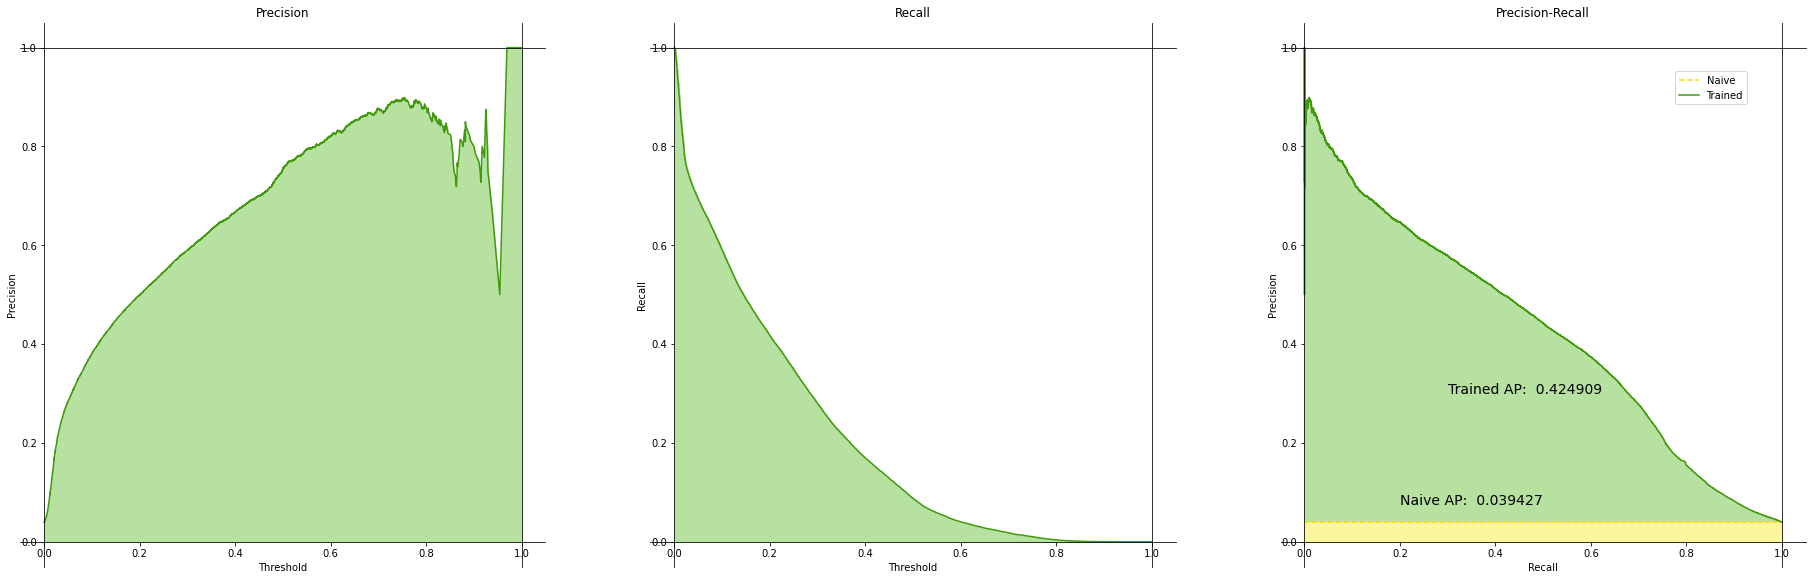

In [0]:
# get values for PR curve
naive_precision, naive_recall, naive_thresholds = precision_recall_curve(y_test, naive_y_prob[:,1])
naive_thresholds = np.append(naive_thresholds, 1)
trained_precision, trained_recall, trained_thresholds = precision_recall_curve(y_test, trained_y_prob[:,1])
trained_thresholds = np.append(trained_thresholds, 1)

# define the plot
plt.clf()
fig, ax = plt.subplots(nrows=1, ncols=3, squeeze=True, figsize=(32,10))

# precision
ax[0].set_title('Precision')
ax[0].plot(trained_thresholds, trained_precision, linestyle='solid', label='Trained', color='xkcd:grass green')
ax[0].fill_between(trained_thresholds, trained_precision, 0, color='xkcd:light grey green')

ax[0].spines['left'].set_position(('data', 0.0))
ax[0].spines['bottom'].set_position(('data', 0.0))
ax[0].spines['right'].set_position(('data', 1.0))
ax[0].spines['top'].set_position(('data', 1.0))

ax[0].set_xlabel('Threshold')
ax[0].set_ylabel('Precision')

# recall
ax[1].set_title('Recall')
ax[1].plot(trained_thresholds, trained_recall, linestyle='solid', label='Trained', color='xkcd:grass green')
ax[1].fill_between(trained_thresholds, trained_recall, 0, color='xkcd:light grey green')

ax[1].spines['left'].set_position(('data', 0.0))
ax[1].spines['bottom'].set_position(('data', 0.0))
ax[1].spines['right'].set_position(('data', 1.0))
ax[1].spines['top'].set_position(('data', 1.0))

ax[1].set_xlabel('Threshold')
ax[1].set_ylabel('Recall')

# precision-recall curve

test_positive_prop = len(y_test[y_test==1]) / len(y_test)

ax[2].set_title('Precision-Recall')
ax[2].plot([0,1], [test_positive_prop,test_positive_prop], linestyle='--', label='Naive', color='xkcd:sunflower yellow')
ax[2].plot(trained_recall, trained_precision, linestyle='solid', label='Trained', color='xkcd:grass green')

# shade the area under the curve
ax[2].fill_between(trained_recall, trained_precision, 0, color='xkcd:light grey green')
ax[2].fill_between([0,1], [test_positive_prop,test_positive_prop], 0, color='xkcd:buff')

# label each curve with is ROC AUC score
ax[2].text(.2, .075, 'Naive AP:  {0:.6f}'.format(naive_ap), fontsize=14)
ax[2].text(.3, .3, 'Trained AP:  {0:.6f}'.format(trained_ap), fontsize=14)

# adjust the axes to intersect at (0,0) and (1,1)
ax[2].spines['left'].set_position(('data', 0.0))
ax[2].axes.spines['bottom'].set_position(('data', 0.0))
ax[2].axes.spines['right'].set_position(('data', 1.0))
ax[2].axes.spines['top'].set_position(('data', 1.0))

# axis labels
ax[2].set_xlabel('Recall')
ax[2].set_ylabel('Precision')

# show the legend
ax[2].legend(loc=(0.75, 0.85))

Starting with the precision curve on the far left-hand of the output, we can see that, in general, our model's ability to make accurate positive class predictions increases as we raise the threshold.  This is kind of like saying that the stronger the evidence, *i.e.* the higher the threshold requirement, the higher the percentage of correct predictions we'll make.  

So, what's happening with precision as we get around the 0.8 threshold?  The erratic nature of the chart above this threshold likely reflects a low number of positive class predictions with probabilities in this range.  We will tackle why our model struggles to predict positive class instances with greater certainty in the next step of this notebook.

And what about the naive model's precision (not plotted)? In our naive model, we state that every member has a positive class probability equivalent to the proportion of positive class members in the overall training dataset, about 3%.  Below a threshold of that same 3% value (~0.03) , we'd guess every instance is in the positive class but would only be correct about 4% of the time, roughly the proportion of positive class members in the testing set. Above that threshold, we'd fail to make any positive class predictions so that there'd be no precision metric to calculate.

Now we consider recall or the percentage of our actual positive class members we're able to identify through model prediction. If we set the threshold to 0, we can capture them all because we assume every instance is in the positive class.  Jumping back to the precision chart, you should see that only roughly 4% of those predictions would be correct. So while we'd identify all our positive class members at the zero threshold, we'd make a bunch of false positive predictions too. As the threshold is raised, we start missing more and more positive class instances until we are hardly capturing any positive class instances at all.

And the naive model? Below the ~0.03 threshold, the naive model would capture every positive instance because we assigned each instance a probability of roughly that value. But as soon as we cross that ~0.03 threshold, we're making no more positive class predictions and miss all positive class instances.

Considering how the precision and recall curves behave as thresholds move up and down, we can see there is a tug-of-war between these two metrics.  Move the threshold lower, you can capture more positive class instances which increases recall, but you'll also pick up a lot of incorrect predictions which lowers precision. Move the threshold higher, the accuracy of our positive class predictions increases though we are failing to predict more and more actual positive instances. 

This relationship is captured in the precision-recall curve (PRC). In an ideal situation, we predict each class instance with 100% certainty so that our precision is always 1.0 and our recall is 1.0 regardless of the threshold.  In the real world, our goal is to move our model increasingly closer to this ideal state, pushing the PRC towards the upper right-hand corner of the plot area.  As you can see from this chart, we have a lot of ground to cover before we start approaching this ideal. To summarize how far from this ideal we are, we can calculate an average precision (AP) score, which like AUC, will approach 1.00 as we move towards the ideal PRC. 

So, how does the naive model fit into the PRC? Remember that our naive model has about a 4% precision for thresholds at or below roughly 3% (~0.03).  (Again, these two values reflect the percentage of positive class members in the testing and training datasets, respectively.) Our model also has a 100% recall at thresholds at or below roughly 3% but then no recall as the threshold moves above this mark as it no longer identifies any positive instances. What this means for our PRC curve is that precision and recall have a fixed relationship in the naive scenario which we can illustrate with a horizontal bar set to the proportion of positive class instances in the testing class, about 4%.  This line does not vary as precision and recall have a fixed relationship at or below the identified threshold.

###Step 3: Explore Class Weightings & Log Loss

The AP score provides us a means to assess our model's overall ability to make positive class predictions.  We will use it as our primary evaluation metric.  That said, we need to examine one more critical metric: log loss.

Internally, many Machine Learning algorithms perform iterative optimization focused on minimizing model error.  Log loss is one popular error calculation used within Machine Learning algorithms.  In a nutshell, log loss calculates the gap between a class, *i.e.* 0 or 1, and the prediction probability associated with it.  The logarithmic-part of the metric refers to how the penalty exponentially grows as the probability moves further and further from an instances class assignment. 

By working to minimize log loss, the model is pushed to be more and more certain about its predictions.  But because there are a disproportionate number of negative class instances in the dataset, the model will receive the greatest reward if it learns to be more confident in its negative class predictions.  Uncertain positive class predictions impact the overall log loss score very little as there are simply far fewer positive class members in the set.

At a minimum, we need our model to put our negative and positive class instances on equal footing for the log loss calculation.  This can be done by multiplying the penalty associated with negative and positive class instances by a weight that reflects the proportion of the other class in the dataset.  This can be done by supplying the string 'balanced' to the *class_weight* argument of many ML model types:

In [0]:
# train the model
balanced_model = LogisticRegression(max_iter=10000, class_weight='balanced')
balanced_model.fit(X_train, y_train)

# predict
balanced_y_prob = balanced_model.predict_proba(X_test)

# score
balanced_ap = average_precision_score(y_test, balanced_y_prob[:,1])

# calculate accuracy
print('Trained AP:\t\t{0:.6f}'.format(trained_ap))
print('Balanced Model AP:\t{0:.6f}'.format(balanced_ap))

Trained AP:		0.424909
Balanced Model AP:	0.392876


To more clearly see the weights used to balance the two classes, we can call the *compute_class_weight* utility which returns the same results as those generated by providing the 'balanced' value in the previous model run.  The first weight is assigned to the negative class and reduces its influence.  The second weight is assigned to the positive class and increases its influence:

In [0]:
weights = compute_class_weight(
  'balanced', 
  classes=np.unique(y_train), 
  y=y_train
  )

weights

Out[24]: array([ 0.51722069, 15.017418  ])

It should be noted that a balanced weighting is only a suggested starting point.  This weighting puts the majority and minority class on equal footing and as the results of our last run show, this doesn't always translate into a better model score but instead a model that is equally good or bad at making positive and negative class predictions.

To better understand what balancing the class weights is doing, let's revisit the precision-recall curves from above:

Out[21]: <matplotlib.legend.Legend at 0x7f62649ae400><Figure size 432x288 with 0 Axes>

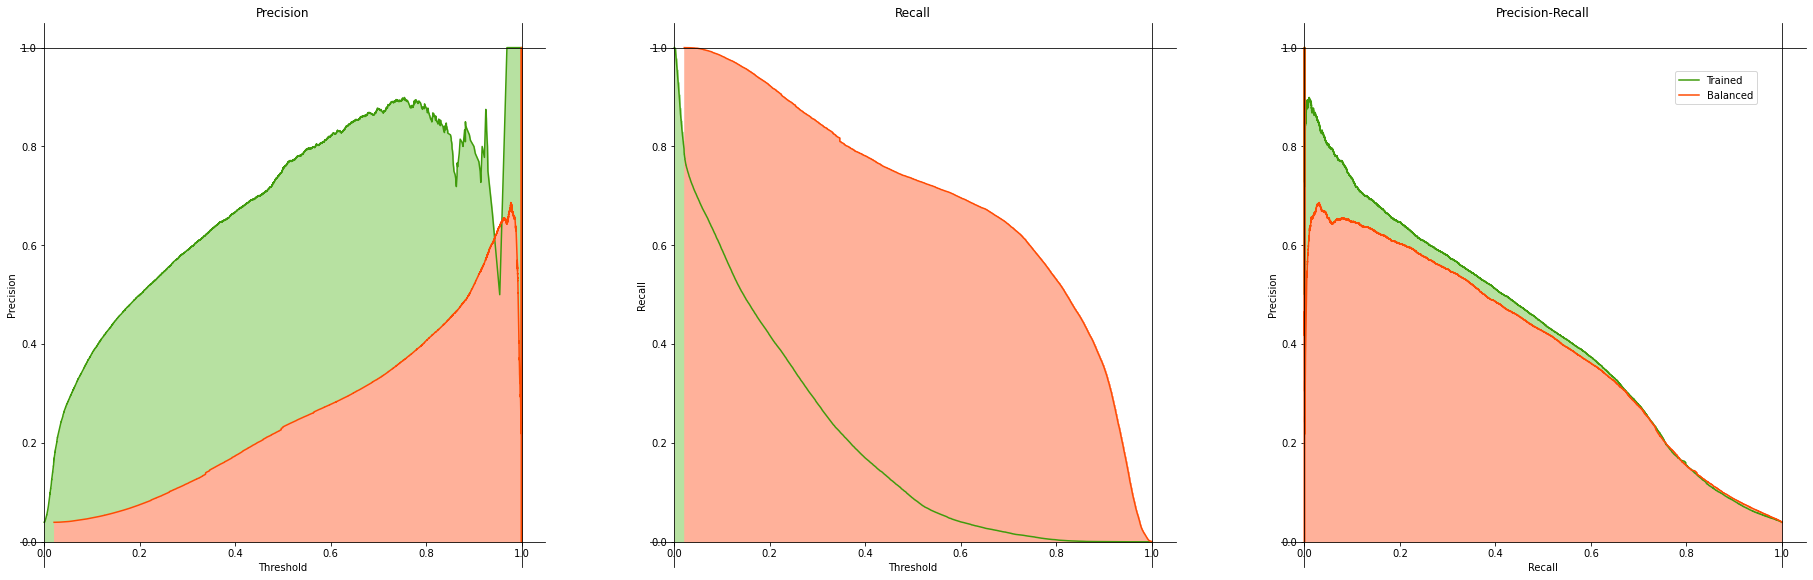

In [0]:
# get values for PR curve
balanced_precision, balanced_recall, balanced_thresholds = precision_recall_curve(y_test, balanced_y_prob[:,1])
balanced_thresholds = np.append(balanced_thresholds, 1)


# define the plot
plt.clf()
fig, ax = plt.subplots(nrows=1, ncols=3, squeeze=True, figsize=(32,10))

# precision
ax[0].set_title('Precision')
ax[0].plot(trained_thresholds, trained_precision, linestyle='solid', label='Trained', color='xkcd:grass green')
ax[0].plot(balanced_thresholds, balanced_precision, linestyle='solid', label='Balanced', color='xkcd:blood orange')

ax[0].fill_between(trained_thresholds, trained_precision, 0, color='xkcd:light grey green')
ax[0].fill_between(balanced_thresholds, balanced_precision, 0, color='xkcd:pale salmon')

ax[0].spines['left'].set_position(('data', 0.0))
ax[0].spines['bottom'].set_position(('data', 0.0))
ax[0].spines['right'].set_position(('data', 1.0))
ax[0].spines['top'].set_position(('data', 1.0))

ax[0].set_xlabel('Threshold')
ax[0].set_ylabel('Precision')

# recall
ax[1].set_title('Recall')
ax[1].plot(trained_thresholds, trained_recall, linestyle='solid', label='Trained', color='xkcd:grass green')
ax[1].plot(balanced_thresholds, balanced_recall, linestyle='solid', label='Balanced', color='xkcd:blood orange')

ax[1].fill_between(trained_thresholds, trained_recall, 0, color='xkcd:light grey green')
ax[1].fill_between(balanced_thresholds, balanced_recall, 0, color='xkcd:pale salmon')

ax[1].spines['left'].set_position(('data', 0.0))
ax[1].spines['bottom'].set_position(('data', 0.0))
ax[1].spines['right'].set_position(('data', 1.0))
ax[1].spines['top'].set_position(('data', 1.0))

ax[1].set_xlabel('Threshold')
ax[1].set_ylabel('Recall')

# precision-recall curve

ax[2].set_title('Precision-Recall')
ax[2].plot(trained_recall, trained_precision, linestyle='solid', label='Trained', color='xkcd:grass green')
ax[2].plot(balanced_recall, balanced_precision, linestyle='solid', label='Balanced', color='xkcd:blood orange')

# shade the area under the curve
ax[2].fill_between(trained_recall, trained_precision, 0, color='xkcd:light grey green')
ax[2].fill_between(balanced_recall, balanced_precision, 0, color='xkcd:pale salmon')

# adjust the axes to intersect at (0,0) and (1,1)
ax[2].spines['left'].set_position(('data', 0.0))
ax[2].axes.spines['bottom'].set_position(('data', 0.0))
ax[2].axes.spines['right'].set_position(('data', 1.0))
ax[2].axes.spines['top'].set_position(('data', 1.0))

# axis labels
ax[2].set_xlabel('Recall')
ax[2].set_ylabel('Precision')

# show the legend
ax[2].legend(loc=(0.75, 0.85))

The  curves very clearly show what's happening by applying balanced class weights. By putting the minority class on equal footing with the majority class, our positive class prediction accuracy (precision) increases more gradually as the threshold increases.  This would indicate our model is making a wider range of positive class predictions, not just predicting the "safe-bet" positives. The greater assertiveness of our model in terms of positive class prediction results in a greater number of our positive class instances being identified as illustrated by the recall chart.

Combined, the drop in precision with class balancing pushes the area under the PRC lower.  Still, it seems our model is poised to be a more reliable predictor of churn than before.

One last thing to note with regard to class weightings is that there's no need to apply a single weight to all members of a given class.  Instead, weights can be assigned at a per-instance level, a technique known as a sample weighting.  While not shown in these notebooks, such an approach would allow us to value different instances of the positive class based on metrics such as CLV.  Such an approach would allow us to train our model for  maximum profit retention. As [techniques evolve](https://www.sciencedirect.com/science/article/abs/pii/S0377221718310166), this may be an aspect of this exercise worth revisiting.

###Step 4: Evaluate Different Algorithms

Another suggestion for dealing with class imbalance is to explore different algorithms to see if some may perform better than others in combination with a particular dataset.  Earlier, we used a Logistic Regression algorithm while  Random Forests, Gradient Boosted Trees and Neural Networks have all been shown to produce good results in these scenarios. To see how each behaves with our dataset, we'll train an instance of each, using mostly default parameter settings to see how they perform *out of the box*.  This is by no means an exhaustive evaluation of each model, but ideally it will point us towards one or more model types that may be a good match for our data:

In [0]:
# train the model
lreg_model = LogisticRegression(max_iter=10000, class_weight='balanced')
lreg_model.fit(X_train, y_train)

# predict
lreg_y_prob = lreg_model.predict_proba(X_test)

# evaluate
lreg_ap = average_precision_score(y_test, lreg_y_prob[:,1])

In [0]:
mlflow.sklearn.autolog()
# Configure the MLflow experiment
mlflow.set_experiment("/Users/dipika.dhara@kasmo.co/churn/Random Forest")
with mlflow.start_run():

    n_estimators = 1000
    max_depth = 6
    max_features = 3
    # train the model
    rfc_model = RandomForestClassifier(class_weight='balanced',n_estimators = n_estimators, max_depth = max_depth, max_features = max_features)
    rfc_model.fit(X_train, y_train)

    # predict
    rfc_y_prob = rfc_model.predict_proba(X_test)

    # evaluate
    rfc_ap = average_precision_score(y_test, rfc_y_prob[:,1])

# # train the model
# rfc_model = RandomForestClassifier(class_weight='balanced')
# rfc_model.fit(X_train, y_train)

# # predict
# rfc_y_prob = rfc_model.predict_proba(X_test)

# # evaluate
# rfc_ap = average_precision_score(y_test, rfc_y_prob[:,1])

2023/07/17 17:28:24 INFO mlflow.tracking.fluent: Experiment with name '/Users/dipika.dhara@kasmo.co/churn/Random Forest' does not exist. Creating a new experiment.


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/databricks/python/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3378, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<command-3659920505602680>", line 3, in <module>
    mlflow.set_experiment("/Users/dipika.dhara@kasmo.co/churn/Random Forest")
  File "/databricks/python/lib/python3.9/site-packages/mlflow/tracking/fluent.py", line 121, in set_experiment
    experiment_id = client.create_experiment(experiment_name)
  File "/databricks/python/lib/python3.9/site-packages/mlflow/tracking/client.py", line 501, in create_experiment
    return self._tracking_client.create_experiment(name, artifact_location, tags)
  File "/databricks/python/lib/python3.9/site-packages/mlflow/tracking/_tracking_service/client.py", line 234, in create_experiment
    return self.store.create_experiment(
  File "/databricks/python/lib/python3.9/site-packages/mlflow/store/tracking/rest_store.py", line 95, in create_experimen

In [0]:

# normalize class weights so that positive class reflects a 1.0 weight on negative class
# scale = weights[1]/weights[0]

# # train the model
# xgb_model = XGBClassifier(scale_pos_weight=scale) # similar to class_weights arg but applies to positive class only
# xgb_model.fit(X_train, y_train)

# # predict
# xgb_y_prob = xgb_model.predict_proba(X_test)

# # evaluate
# xgb_ap = average_precision_score(y_test, xgb_y_prob[:,1])
weights = compute_class_weight(
  'balanced', 
  classes=np.unique(y_train), 
  y=y_train
  )
import mlflow.xgboost
mlflow.xgboost.autolog()
with mlflow.start_run():
    scale = weights[1]/weights[0]

    # train the model
    xgb_model = XGBClassifier(scale_pos_weight=scale) # similar to class_weights arg but applies to positive class only
    xgb_model.fit(X_train, y_train)

    # predict
    xgb_y_prob = xgb_model.predict_proba(X_test)

    # evaluate
    xgb_ap = average_precision_score(y_test, xgb_y_prob[:,1])

**NOTE** The MLP Classifier does not support class or sample weighting.

In [0]:
# train the model
mlp_model = MLPClassifier(activation='relu', max_iter=1000)  # does not support class weighting
mlp_model.fit(X_train, y_train)

# predict
mlp_y_prob = mlp_model.predict_proba(X_test)

# evaluate
mlp_ap =  j(y_test, mlp_y_prob[:,1])

Let's now compare the evaluation metric for each model:

In [0]:
print('Logistic Regression AP:\t\t{0:.6f}'.format(lreg_ap))
print('RandomForest Classifier AP:\t{0:.6f}'.format(rfc_ap))
print('XGBoost Classifier AP:\t\t{0:.6f}'.format(xgb_ap))
print('MLP (Neural Network) AP:\t{0:.6f}'.format(mlp_ap))

Logistic Regression AP:		0.392876
RandomForest Classifier AP:	0.331983
XGBoost Classifier AP:		0.429339
MLP (Neural Network) AP:	0.426761


Of our models, the XGBClassifier performed the best (followed closely by the neural network). This isn't terribly surprising given that XGBoost is featured heavily in many data classification competitions these days and is recognized as [relatively insensitive to class imbalances](https://www.sciencedirect.com/science/article/pii/S095741741101342X) such as are found in this particular dataset.

The XGBoost Classifier used above is but one of many gradient boosting classifiers available to us.  LightGBM is another popular of these model-types, and sklearn makes available the HistGradientBoostingClassifier which mimics its functionality:

**NOTE** The HistGradientBoostingClassifier doesn't support class weights so that we'll use sample weights with each instance in the set assigned weights which achieve the same effect.

In [0]:
# compute sample weights (functionally equivalent to class weights when done in this manner)
sample_weights = compute_sample_weight(
  'balanced', 
  y=y_train
  )

# train the model
hgb_model = HistGradientBoostingClassifier(loss='binary_crossentropy', max_iter=1000)
hgb_model.fit(X_train, y_train, sample_weight=sample_weights)  # weighting applied to individual samples

# predict
hgb_y_prob = hgb_model.predict_proba(X_test)

# evaluate
hgb_ap = average_precision_score(y_test, hgb_y_prob[:,1])
print('HistGB Classifier AP:\t{0:.6f}'.format(hgb_ap))

HistGB Classifier AP:	0.438548


The HistGradientBoostingClassifier did very well.  Still, it's difficult to say that any one of the models we trained here is truly *better* than the others based on the limited evaluation we've performed.  Instead, we should consider tuning each model to get it's best predictions and then see how the models compare before eliminating any from consideration.  Still, time is limited so that we'll go ahead and drop random forests and logistic regression from consideration moving forward as some limited testing on this dataset (along with information in the literature) would indicate they are not likely to provide us our best results.

One last model worth considering is the voting classifier.  This model type combines the predictions of multiple models to create an ensemble prediction. The *soft* voting setting instructs the model to average the probabilities generated by each of the models provided to it.  If some models performed more reliably than the others, we might apply weighting to the voting calculation to more highly favor those.  In the next notebook, we'll tackle model weighting, but for now, let's see how combining three models with equal weighting affects our evaluation metric:

In [0]:
from sklearn.ensemble import HistGradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier


In [0]:
# train the model
vote_model = VotingClassifier(
  estimators=[
    ('hgb', HistGradientBoostingClassifier(loss='binary_crossentropy', max_iter=1000)), 
    ('xgb', XGBClassifier()),
    ('mlp', MLPClassifier(activation='relu', max_iter=1000))
    ],
  voting='soft'
  )
vote_model.fit(X_train, y_train)

# predict
vote_y_prob = vote_model.predict_proba(X_test)

# evaluate
vote_ap = average_precision_score(y_test, vote_y_prob[:,1])
print('Voting AP:\t{0:.6f}'.format(vote_ap))

Voting AP:	0.446032


Together, these models perform a little better together than they did on their own. After tuning the individual models (in the next notebook), we'll re-consider how a voting ensemble might be used to combine them.

###Step 5: Consider Additional Options

Class imbalances are a particularly stubborn problem in generating reliable classification models. A number of additional strategies for dealing with imbalance have been identified and tend to fall into the categories of:</p>
1. Modifying the algorithm
2. Modifying the dataset

In the category of *modifying the algorithm*, we might (as we did above) consider different classes of models, some of which are less sensitive to class imbalance.  We might also look for opportunities to adjust the penalties (through class weights) used internally by different algorithms when performing iterative optimization to give higher consideration to the minority positive class. We've done a lightweight exploration of these techniques here, something we'll continue working on in the next notebook using our three top performing models plus the voting ensemble.

In the category of *modifying the dataset*, oversampling of the minority class, undersampling of the majority class, or a combination of the two techniques have been shown to help steer models towards more reliable predictions.  [These techniques](https://imbalanced-learn.readthedocs.io/en/stable/introduction.html) may select values from the dataset at random, use ML-guided approaches to identify values to select, or even use ML-guided techniques to synthesize new instances of minority class values or *correct* majority class values.

All that said, the ratio of negative to positive classes in our dataset is roughly 30:1. Most of the techniques in the *modify the dataset* category of techniques tend to be aimed at more highly imbalanced scenarios with class ratios of 100:1 or higher. Through some limited testing (not shown here) we determined that neither weighting nor alternative sampling techniques made significant improvements in our evaluation metrics. That's not to say that such techniques could not make improvements in a 30:1 or lower class imbalance.  One consistent theme in the literature surrounding these techniques is that no one technique is a solve for all imbalance problems and results vary significantly between datasets.

In [0]:
pip install tensorflow

Python interpreter will be restarted.
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.21.5
    Not uninstalling protobuf at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-cfb1ff44-5495-4a60-9591-a73c9cc71743
    Can't uninstall 'protobuf'. No files were found to uninstall.
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Not uninstalling numpy at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-cfb1ff44-5495-4a60-9591-a73c9cc71743
    Can't uninstall 'numpy'. No files were found to uninstall.
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.7.1
    Uninstalling typing-extensions-4.7.1:
      Successfully uninstalled typing-extensions-4.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behavi

In [0]:
pip install keras


Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
import tensorflow as tf
from tensorflow import keras

/databricks/python/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [0]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [0]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(856143, 102)
(853903, 102)
(856143,)
(853903,)


In [0]:
X_train.shape[1]

Out[9]: 102

In [0]:
print(y_test)


0         0
1         0
2         0
3         0
4         0
         ..
853898    0
853899    0
853900    0
853901    0
853902    0
Name: is_churn, Length: 853903, dtype: int64


In [0]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score, f1_score

# Create a neural network model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(102,)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model and store the training history
history = model.fit(X_train, y_train, epochs=2, batch_size=32, validation_data=(X_test, y_test))

# Extract the training and test accuracy from the history
train_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']
# Make predictions on the test dataset
test_predictions = model.predict(X_test)
# Calculate average precision
average_precision = average_precision_score(y_test, test_predictions)

# Calculate F-score
threshold = 0.5  # Threshold for converting probabilities to binary predictions
binary_predictions = (test_predictions > threshold).astype(int)
f_score = f1_score(y_test, binary_predictions)

# Print the average precision and F-score
print('Average Precision:', average_precision)
print('F-score:', f_score)

# Plot the accuracy values
epochs = range(1, len(train_acc) + 1)
plt.plot(epochs, train_acc, 'bo', label='Train Accuracy')
plt.plot(epochs, test_acc, 'r', label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



Epoch 1/2
 4996/26755 [====>.........................] - ETA: 30s - loss: 0.1057 - accuracy: 0.9685

*** WARNING: max output size exceeded, skipping output. ***

26685/26685 [==============================] - 35s 1ms/step


---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-3659920505602700>:29
     27 threshold = 0.5  # Threshold for converting probabilities to binary predictions
     28 binary_predictions = (test_predictions > threshold).astype(int)
---> 29 f_score = f1_score(y_test, binary_predictions)
     31 # Print the average precision and F-score
     32 print('Average Precision:', average_precision)

NameError: name 'f1_score' is not defined

In [0]:
from sklearn.metrics import average_precision_score, f1_score
# Calculate average precision
average_precision = average_precision_score(y_test, test_predictions)

# Calculate F-score
threshold = 0.5  # Threshold for converting probabilities to binary predictions
binary_predictions = (test_predictions > threshold).astype(int)
f_score = f1_score(y_test, binary_predictions)
# print(test_predictions)
# Print the average precision and F-score
print('Average Precision:', average_precision)

print('F-score:', f_score)

Average Precision: 0.43461257648568297
F-score: 0.19692910140148395


In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


print(classification_report(y_test, test_predictions))

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<command-3510043554929382> in <cell line: 5>()
      3 
      4 
----> 5 print(classification_report(y_test, test_predictions))

/databricks/python/lib/python3.9/site-packages/sklearn/utils/validation.py in inner_f(*args, **kwargs)
     61             extra_args = len(args) - len(all_args)
     62             if extra_args <= 0:
---> 63                 return f(*args, **kwargs)
     64 
     65             # extra_args > 0

/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py in classification_report(y_true, y_pred, labels, target_names, sample_weight, digits, output_dict, zero_division)
   1968     """
   1969 
-> 1970     y_type, y_true, y_pred = _check_targets(y_true, y_pred)
   1971 
   1972     if labels is None:

/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py in _chec

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                1648      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
 dropout_2 (Dropout)         (None, 1)                 0         
                                                                 
Total params: 1937 (7.57 KB)
Trainable params: 1937 (7.5

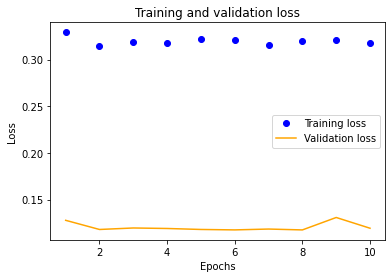

In [0]:
# for modeling
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
# build a model
model = Sequential()
model.add(Dense(16, input_shape=(X_train.shape[1],), activation='relu')) # Add an input shape! (features,)
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.add(Dropout(0.5))
model.summary() 

# compile the model
model.compile(optimizer='Adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

# early stopping callback
# This callback will stop the training when there is no improvement in  
# the validation loss for 10 consecutive epochs.  
es = EarlyStopping(monitor='val_accuracy', 
                                   mode='max', # don't minimize the accuracy!
                                   patience=10,
                                   restore_best_weights=True)

# now we just update our model fit call
history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=10, # you can set this to a big number!
                    batch_size=10,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)

history_dict = history.history
# Learning curve(Loss)
# let's see the training and validation loss by epoch

# loss
loss_values = history_dict['loss'] # you can change this
val_loss_values = history_dict['val_loss'] # you can also change this

# range of X (no. of epochs)
epochs = range(1, len(loss_values) + 1) 

# plot
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
# Extract the training and test accuracy from the history
train_acc = history_dict['accuracy']
test_acc = history_dict['val_accuracy']
print(train_acc)
print(test_acc)

[0.9635311961174011, 0.9672324061393738, 0.9671929478645325, 0.9673243761062622, 0.9673389792442322, 0.9672601222991943, 0.967400312423706, 0.9673812985420227, 0.967400312423706, 0.9673740267753601]
[0.9662206768989563, 0.9668455719947815, 0.9668046832084656, 0.9668046832084656, 0.9675288796424866, 0.9674704670906067, 0.9668981432914734, 0.9669799208641052, 0.9662206768989563, 0.9672719240188599]


In [0]:
# Calculate and store the average precision score
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_train, y_test)
print("Average Precision:", average_precision)

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<command-3317987543606200> in <cell line: 3>()
      1 # Calculate and store the average precision score
      2 from sklearn.metrics import average_precision_score
----> 3 average_precision = average_precision_score(y_train, y_test)
      4 print("Average Precision:", average_precision)

/databricks/python/lib/python3.9/site-packages/sklearn/utils/validation.py in inner_f(*args, **kwargs)
     61             extra_args = len(args) - len(all_args)
     62             if extra_args <= 0:
---> 63                 return f(*args, **kwargs)
     64 
     65             # extra_args > 0

/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_ranking.py in average_precision_score(y_true, y_score, average, pos_label, sample_weight)
    222     average_precision = partial(_binary_uninterpolated_average_precision,
    223                

In [0]:
import numpy as np
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
y_scores = model.predict(X_test)

# Calculate average precision
average_precision = average_precision_score(y_test, y_scores)
print("Average Precision:", average_precision)

 7804/26685 

*** WARNING: max output size exceeded, skipping output. ***

26685/26685 [==============================] - 39s 1ms/step


In [0]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# Create a neural network model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(102,)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model and store the training history
history = model.fit(X_train, y_train, epochs=2, batch_size=32, validation_data=(X_test, y_test))

# Extract the training and test accuracy from the history
train_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']
y_scores = model.predict(X_test)

# Calculate average precision
average_precision = average_precision_score(y_test, y_scores)
print("Average Precision:", average_precision)

# Plot the accuracy values
epochs = range(1, len(train_acc) + 1)
plt.plot(epochs, train_acc, 'bo', label='Train Accuracy')
plt.plot(epochs, test_acc, 'r', label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
# Calculate average precision
average_precision = average_precision_score(y_test, y_scores)
print("Average Precision:", average_precision)


In [0]:
# Enable autolog()
# mlflow.sklearn.autolog() requires mlflow 1.11.0 or above.
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score, f1_score
import mlflow

mlflow.sklearn.autolog()

# With autolog() enabled, all model parameters, a model score, and the fitted model are automatically logged.  
with mlflow.start_run():
    # Create a neural network model
    model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(102,)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model and store the training history
    history = model.fit(X_train, y_train, epochs=2, batch_size=32, validation_data=(X_test, y_test))

    # Extract the training and test accuracy from the history
    train_acc = history.history['accuracy']
    test_acc = history.history['val_accuracy']
    # Make predictions on the test dataset
    test_predictions = model.predict(X_test)
    # # Calculate average precision
    # average_precision = average_precision_score(y_test, test_predictions)

    # # Calculate F-score
    # threshold = 0.5  # Threshold for converting probabilities to binary predictions
    # binary_predictions = (test_predictions > threshold).astype(int)
    # f_score = f1_score(y_test, binary_predictions)

    # # Print the average precision and F-score
    # print('Average Precision:', average_precision)
    # print('F-score:', f_score)

    # # Plot the accuracy values
    # epochs = range(1, len(train_acc) + 1)
    # plt.plot(epochs, train_acc, 'bo', label='Train Accuracy')
# plt.plot(epochs, test_acc, 'r', label='Test Accuracy')
# plt.title('Training and Test Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

  File <command-1867917593249796>:14
    model = keras.Sequential([
    ^
IndentationError: expected an indented block


In [0]:
pip install mlflow

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
pip uninstall typing-extensions tensorflow keras

Python interpreter will be restarted.
Found existing installation: typing-extensions 4.1.1
Not uninstalling typing-extensions at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-bcac381e-d104-4b77-8ebc-054819c18fbd
Can't uninstall 'typing-extensions'. No files were found to uninstall.
Found existing installation: tensorflow 2.13.0
Not uninstalling tensorflow at /local_disk0/.ephemeral_nfs/cluster_libraries/python/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-bcac381e-d104-4b77-8ebc-054819c18fbd
Can't uninstall 'tensorflow'. No files were found to uninstall.
Found existing installation: keras 2.13.1
Not uninstalling keras at /local_disk0/.ephemeral_nfs/cluster_libraries/python/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-bcac381e-d104-4b77-8ebc-054819c18fbd
Can't uninstall 'keras'. No files were found to uninstall.
Python interpreter

In [0]:
import mlflow
import mlflow.tensorflow
import mlflow.keras
import mlflow.sklearn
import tensorflow as tf
from tensorflow import keras

# Set the MLflow tracking URI to point to your MLflow server
# mlflow.set_tracking_uri("databricks")

# Configure the MLflow experiment
# mlflow.set_experiment("/databricks/experiment/path")

# Enable autologging for TensorFlow and Keras
mlflow.tensorflow.autolog()

# Start a new MLflow run
with mlflow.start_run():
    # Create a neural network model
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(102,)),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model and store the training history
    model.fit(X_train, y_train, epochs=2, batch_size=32, validation_data=(X_test, y_test))

    # Log the model
    mlflow.tensorflow.log_model(model, "model")

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test)

    # Log the test metrics
    mlflow.log_metrics({'test_loss': test_loss, 'test_accuracy': test_accuracy})


2023/07/17 19:11:11 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


Epoch 1/2
 5311/26755 [====>.........................] - ETA: 28s - loss: 0.1038 - accuracy: 0.9687

*** WARNING: max output size exceeded, skipping output. ***

1/1 [==============================] - 0s 62ms/step
INFO:tensorflow:Assets written to: /tmp/tmpb732lzz4/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpb732lzz4/model/data/model/assets
2023/07/17 19:14:42 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.5.0/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.
2023/07/17 19:14:42 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmpakcwhjpc/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpakcwhjpc/model/data/model/assets


 7489/26685 [=======>......................] - ETA: 18s - loss: 0.1140 - accuracy: 0.9630

*** WARNING: max output size exceeded, skipping output. ***

26685/26685 [==============================] - 26s 957us/step - loss: 0.1126 - accuracy: 0.9632
